In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/TSphere/NN/01

/content/drive/MyDrive/TSphere/NN/01


## Семинар 1 "Полносвязные нейронные сети"

ФИО: Крапивин Богдан Александрович


В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=https://github.com/BangodKA/msu_nn_spring_2021/blob/master/backprop.pdf?raw=1 width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times m}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}w_{jt}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [4]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimension of inputs is *input_size*, of output: *output_size*.
        '''
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X @ self.W + self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''

        #y = WX + b
        #dLdW = dLdy * dydw
        #dydw = x

        self.dLdW = (dLdy.T @ self.X).T
        self.dLdb = dLdy

        dLdx = dLdy @ self.W.T

        return dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''

        self.W -= learning_rate * self.dLdW
        self.b -= learning_rate * np.sum(self.dLdb, axis=0)

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [5]:
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    eps = 10**(-5)

    f_grad = np.zeros(gradient.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps
            f_r = func(X)
            X[i, j] -= 2 * eps
            f_l = func(X)
            X[i, j] += eps
            f_grad[i, j] = (f_r - f_l) / 2 / eps
    return np.max(np.abs(gradient - f_grad))

In [6]:
np.random.seed(777)
x = np.random.rand(10, 20)
def func(x): return (x**2).sum()


gradient = 2*x
check_gradient(func, x, gradient)

5.662181834509283e-10

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [7]:
np.random.seed(777)

X = np.array([[0, 1], [1, 1]])
Y = np.array([[0], [1]])

l = Linear(2, 1)


def loss(W):
    l.W = W

    res = l.forward(X)
    return np.sum((res - Y)**2)


res = l.forward(X)
print(res)
dLdy = 2*(res - Y)
print(dLdy)

l.backward(dLdy)

print(l.dLdW)

check_gradient(loss, l.W, l.dLdW)

[[-0.00822825]
 [-0.01291034]]
[[-0.0164565 ]
 [-2.02582067]]
[[-2.02582067]
 [-2.04227717]]


9.583001059354501e-12

### Часть 3: Сигмоида

In [8]:
class Sigmoid:
    def __init__(self):
        pass

    def __sigmoid__(self, arg):
        return 1 / (1 + np.exp(-arg))

    def __sigmoid_deriv__(self):
        return self.sigm * (1 - self.sigm)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.sigm = self.__sigmoid__(X)
        return self.sigm

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
#         assert(dLdy.shape == self.X.shape)
        dLdx = dLdy * self.__sigmoid_deriv__()

        return dLdx

    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [9]:
np.random.seed(777)

X = np.array([[0.0, 1.0], [-1.0, 1.0]])
Y = np.array([[1.0, -1], [1, 0]])


l = Sigmoid()


def loss(X_):
    res = l.forward(X_)
    return np.sum((res - Y)**2)


res = l.forward(X)
# print(res)
dLdy = 2*(res - Y)
# print(dLdy)

dLdx = l.backward(dLdy)
# print(dLdx)

check_gradient(loss, X, dLdx)

3.407418791567807e-11

### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [10]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        # YOUR CODE HERE
        # (Hint: No code is expected here, just joking)
        pass

    def __softmax__(self):

        e_x = np.exp(self.X - np.mean(self.X, axis=1)[:, np.newaxis])
        return e_x / e_x.sum(axis=1)[:, np.newaxis]

    def __nll__(self):
        expected_classes_probs = self.softmax[np.arange(len(self.y)), self.y]
        log_lkh = np.log(expected_classes_probs)
        return -np.mean(log_lkh)

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y
        self.softmax = self.__softmax__()
        return self.__nll__()

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = self.softmax
        dLdx[np.arange(len(self.y)), self.y] -= 1
        dLdx /= self.softmax.shape[0]
        return dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [11]:
np.random.seed(777)

X = np.array([[6.0, 5.0, 7], [3.0, 4.0, 9], [7.0, 4.0, 9]])
Y = np.array([2, 0, 1])

l = NLLLoss()


def loss(X_):
    return l.forward(X_, Y)


l.forward(X, Y)

dLdx = l.backward()
print(dLdx)

check_gradient(loss, X, dLdx)

[[ 0.08157616  0.03001019 -0.11158635]
 [-0.33251463  0.00222547  0.33028916]
 [ 0.03949988 -0.33136675  0.29186687]]


3.093246492280599e-11

### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [12]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.layers = modules

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for layer in self.layers[::-1]:
            dLdy = layer.backward(dLdy)
#             layer.step(self.lr)

    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

### Часть 6, обучение на простых данных

In [13]:
%cd drive/MyDrive/TSphere/Second/NN/Tasks/01

[Errno 2] No such file or directory: 'drive/MyDrive/TSphere/Second/NN/Tasks/01'
/content/drive/MyDrive/TSphere/NN/01


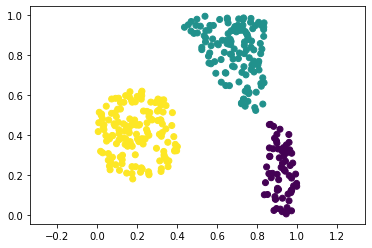

In [14]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

Отличная визуализация: http://playground.tensorflow.org/

In [136]:
modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
net = NeuralNetwork(modules)
lr = 0.05
n_epoch = 100000
loss_layer = NLLLoss()
nll_conv = []

In [137]:
for i in range(n_epoch):
    res = net.forward(X)
    nll = loss_layer.forward(res, y)
    nll_conv.append(nll)
    nll_grad = loss_layer.backward()
    net.backward(nll_grad)
    net.step(lr)

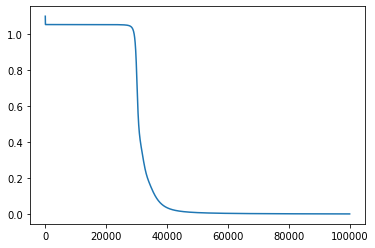

In [138]:
plt.plot(nll_conv)
plt.show()

In [139]:
size_grid = 90
x_grid = np.linspace(-0.2, 1.2, size_grid)
y_grid = np.linspace(0, 1, size_grid)
x_, y_ = np.meshgrid(x_grid, y_grid)

In [140]:
X_square = np.dstack((x_, y_)).reshape(size_grid ** 2, 2)
predict = np.argmax(net.forward(X_square), 1)

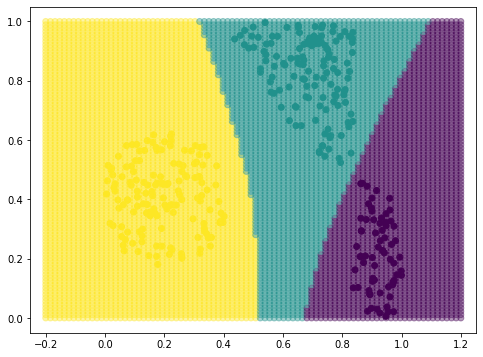

In [141]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6)  
plt.scatter(X_square[:, 0], X_square[:, 1], c=predict, alpha=0.4)

data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.axis('equal')
plt.show()

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

### Первая часть

In [21]:
n_epoch = 50000
modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
lrs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

In [22]:
all_nll = []
for lr in lrs:
    net = NeuralNetwork(modules)
    loss_layer = NLLLoss()
    nll_conv = []
    for i in range(n_epoch):
        res = net.forward(X)
        nll = loss_layer.forward(res, y)
        nll_conv.append(nll)
        nll_grad = loss_layer.backward()
        net.backward(nll_grad)
        net.step(lr)
    all_nll.append(nll_conv)

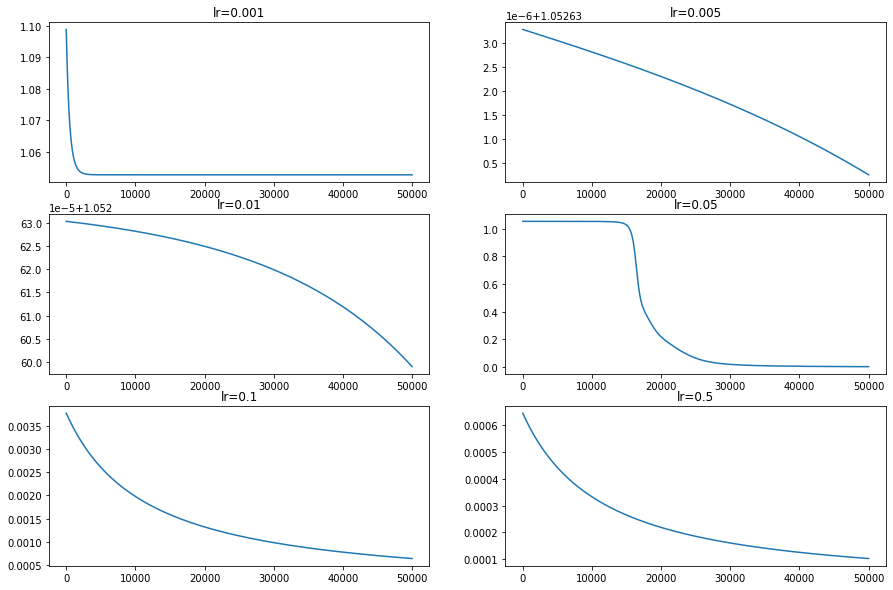

In [23]:
fig = plt.figure(figsize=(15,10))

for i in range(len(lrs)):
    ax = fig.add_subplot(321 + i)
    ax.set_title(f'lr={lrs[i]}')
    ax.plot(all_nll[i])

plt.show()

In [24]:
optimal_nll = [np.array(nll[:-1000]).mean() for nll in all_nll]

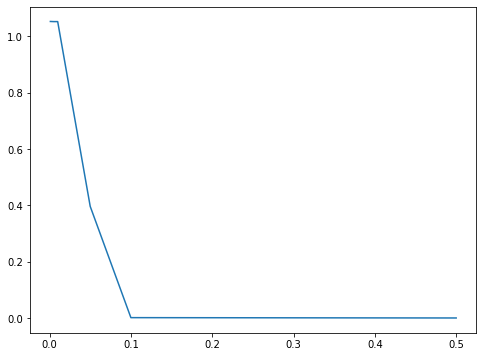

In [25]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6) 
plt.plot(lrs, optimal_nll)

plt.show()

### Вторая часть

In [99]:
class MSELoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        self.preds = X
        self.obs = y[:, np.newaxis]
        return ((self.preds - self.obs) ** 2).sum() / self.obs.shape[0]
            
    def backward(self):
        dLdx = 2 * (self.preds - self.obs) / self.obs.shape[0]
        return dLdx
    def step(self, learning_rate):
        pass

In [130]:
modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)]
net = NeuralNetwork(modules)
lr = 0.05
n_epoch = 100000
loss_layer = MSELoss()
nll_conv = []

In [131]:
for i in range(n_epoch):
    res = net.forward(X)
    nll = loss_layer.forward(res, y)
    nll_conv.append(nll)
    nll_grad = loss_layer.backward()
    net.backward(nll_grad)
    net.step(lr)

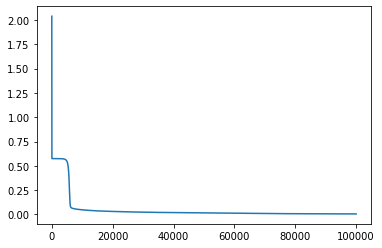

In [132]:
plt.plot(nll_conv)
plt.show()

In [133]:
size_grid = 90
x_grid = np.linspace(-0.2, 1.2, size_grid)
y_grid = np.linspace(0, 1, size_grid)
x_, y_ = np.meshgrid(x_grid, y_grid)

In [134]:
X_square = np.dstack((x_, y_)).reshape(size_grid ** 2, 2)
predict = np.around(net.forward(X_square))

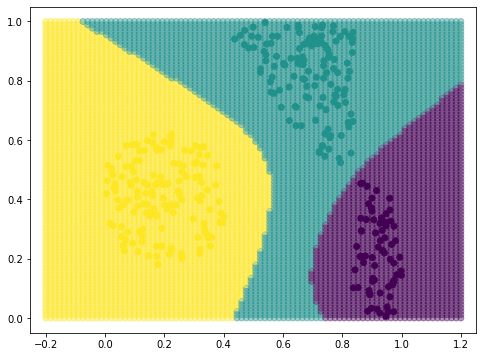

In [135]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(6)  
plt.scatter(X_square[:, 0], X_square[:, 1], c=predict, alpha=0.4)

data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.axis('equal')
plt.show()

Поверхность стала менее линейной, точнее выделяя классы